<a href="https://colab.research.google.com/github/ccasanoval/RLtests/blob/master/stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install gymnasium
!pip install stable_baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 36.1 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed


df:         Open   High    Low  Close   Volume
1175  3.114  3.142  3.082  3.114  1601368
1176  3.036  3.036  2.954  2.994  2907997
1177  3.020  3.060  2.994  3.016  2027933
1178  3.054  3.092  3.002  3.080  1529444
1179  3.076  3.076  3.018  3.052  1157258
1180  3.100  3.100  3.056  3.064   876458
1181  3.080  3.100  3.076  3.090  1109798
1182  3.110  3.118  3.076  3.112  1008883
1183  3.124  3.130  3.092  3.108  2806085
1184  3.110  3.138  3.098  3.120  9026136
1185  3.140  3.146  3.118  3.134  3961012
1186  3.130  3.174  3.126  3.170  3568912
1187  3.182  3.182  3.128  3.128  1233998
1188  3.140  3.140  3.116  3.124   788793
1189  3.126  3.158  3.124  3.148   933400
1190  3.150  3.170  3.138  3.158   938280
1191  3.166  3.218  3.156  3.202  1784929
1192  3.204  3.220  3.186  3.220  1575888
1193  3.224  3.244  3.222  3.234  1497706
1194  3.226  3.248  3.212  3.234  3781519
pct_df:            Open      High       Low     Close    Volume
1175 -0.040074 -0.031443 -0.015964 -0.007015 -0.1

[*********************100%***********************]  1 of 1 completed

--------------------------------
------------------------------------------------------------------------
--------------------------------
action: [[0.        0.8001659]] / reward: [0.]
action: [[0.        0.8058857]] / reward: [0.]
action: [[0.         0.44562557]] / reward: [0.]
action: [[0.8111469 0.       ]] / reward: [0.]
action: [[0. 0.]] / reward: [0.]
action: [[0.22652715 0.        ]] / reward: [0.]
action: [[0. 0.]] / reward: [0.]
action: [[0. 0.]] / reward: [0.]
action: [[0. 0.]] / reward: [0.]
action: [[0.        0.7538062]] / reward: [0.]
action: [[0.51044774 0.        ]] / reward: [0.]
action: [[0. 0.]] / reward: [0.]
action: [[0.20811534 0.6169798 ]] / reward: [0.]
action: [[0.62386376 0.        ]] / reward: [0.]
action: [[0.         0.31393552]] / reward: [0.]
action: [[0. 0.]] / reward: [0.]
action: [[0. 0.]] / reward: [0.]
action: [[1.2714938 0.       ]] / reward: [0.]
action: [[1.548624   0.66399264]] / reward: [462.88992]
action: [[0.         0.02252748]] / reward: [

action: [[0.17814606 0.        ]] / reward: [-493.55264]
action: [[0. 0.]] / reward: [-1435.765]
action: [[1.3536162  0.57395154]] / reward: [-134.60178]
action: [[0. 0.]] / reward: [0.]
action: [[1.723994 1.      ]] / reward: [1031.9597]
action: [[0. 0.]] / reward: [-269.20355]
action: [[0.         0.41292354]] / reward: [628.1544]
action: [[0. 0.]] / reward: [-1256.3088]
action: [[0.         0.16494286]] / reward: [-2422.9143]
action: [[0.2952187 0.4157586]] / reward: [-1884.4633]
action: [[0.5011165 0.       ]] / reward: [-134.60178]
action: [[0.        0.2818147]] / reward: [2557.5159]
action: [[0. 0.]] / reward: [-807.65454]
action: [[0. 0.]] / reward: [-628.1544]
action: [[0.         0.70300865]] / reward: [-314.0525]
action: [[2.577851   0.41133896]] / reward: [633.8928]
action: [[0.7682912 0.       ]] / reward: [1611.1934]
action: [[0.58116674 0.        ]] / reward: [1399.8839]
action: [[0. 0.]] / reward: [792.39264]
action: [[1.2996871 1.       ]] / reward: [1293.1774]
action:

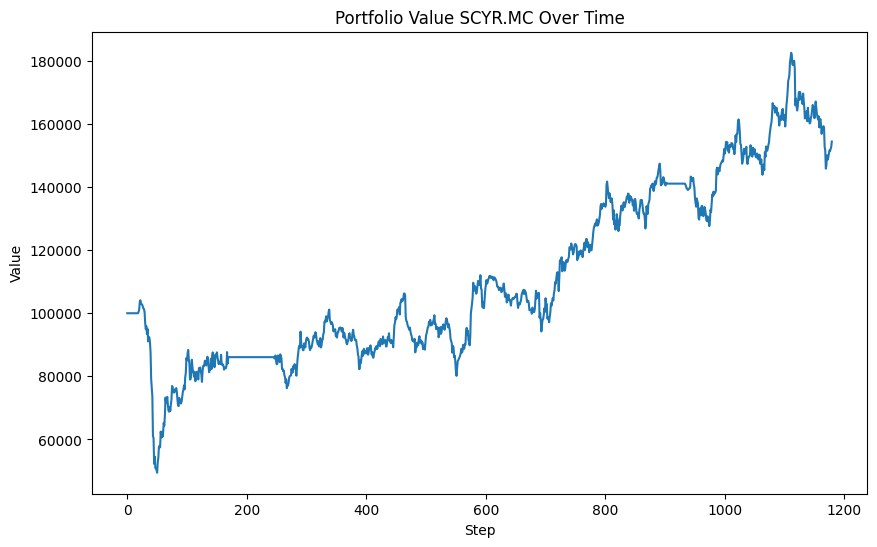

In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Aug 30 11:50:19 2024

@author: cesar.casanova
"""

#!pip install gym pandas yfinance stable-baselines3 shimmy

TRAIN = True

TICKER = "SCYR.MC"
TICKER_TEST = TICKER #"OHLA.MC"

START = "2020-01-01"
END = "2024-08-30"

INITIAL_BALANCE = 2000
TRAIN_STEPS = 100_000

MODEL_NAME = f"stock_{TICKER}_{int(TRAIN_STEPS/1000)}k"

#------------------------------------------------------------------------------
# TRAIN ENVIRONMENT

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import yfinance as yf
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

class StockTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, df, pct_df, max_steps=1000):
        super(StockTradingEnv, self).__init__()

        self.df = df
        self.pct_df = pct_df
        self.reward_range = (-np.inf, np.inf)
        self.action_space = spaces.Box(low=np.array([0, 0]), high=np.array([3, 1]), dtype=np.float16)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(5, 5), dtype=np.float16)
        self.initial_balance = INITIAL_BALANCE
        self.balance = self.initial_balance
        self.shares_held = 0
        self.current_step = 6
        self.max_steps=max_steps
        self.train_cnt_epoch=len(self.df.loc[:, 'Close'].values) -2 -6


    def step(self, action):
      self.current_step += 1

      action_type = action[0]
      amount = action[1]

      close_price = self.df.loc[self.current_step, 'Close']
      next_day_close_price=self.df.loc[self.current_step+1, 'Close']

      shares_bought = 0
      shares_sold = 0
      asset_value_before_action = self.balance + self.shares_held * close_price

      if action_type < 1:
          # Hold
          pass
      elif action_type < 2:
          # Buy
          total_possible = int(self.balance / close_price)
          shares_bought = int(total_possible * amount)
          total_cost = shares_bought * close_price
          self.balance -= total_cost
          self.shares_held += shares_bought
      elif action_type < 3:
          # Sell
          shares_sold = int(self.shares_held * amount)
          self.balance += shares_sold * close_price
          self.shares_held -= shares_sold

      if self.current_step >= self.train_cnt_epoch:
          self.current_step = 6

      obs = self._next_observation()

      asset_value_after_action = self.balance + self.shares_held * next_day_close_price
      reward = asset_value_after_action - asset_value_before_action
      done = self.current_step >= self.max_steps or self.balance <= 0

      return obs, reward, done, done, {}


    def reset(self, seed=0):
        self.balance = self.initial_balance
        self.shares_held = 0
        self.current_step = 6
        obs = self._next_observation()
        return obs, {}

    def _next_observation(self):
        end_slice = self.current_step + 1
        start_slice = end_slice-4
        # in iloc the last index is not inclusive; thus we are doing end_slice+1.
        obs = self.pct_df.iloc[start_slice:end_slice+1].values
        return obs

    def render(self, mode='human'):
        return self.df.loc[self.current_step, 'Open']

    def close(self):
        return


#------------------------------------------------------------------------------
# TRAIN
if TRAIN:
    df = yf.download(TICKER, start=START, end=END)
    df = df.sort_values('Date')
    df = df.drop(columns='Adj Close')
    df = df.reset_index(drop=True)
    pct_df = df.copy()

    for feature in ['Open', 'High', 'Low', 'Close', 'Volume']:
        pct_df[feature] = pct_df[feature].pct_change()

    print("df: ", df.tail(20))
    print("pct_df: ", pct_df.tail(20))

    env = DummyVecEnv([lambda: StockTradingEnv(df, pct_df)])
    model = PPO("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=TRAIN_STEPS)
    model.save(MODEL_NAME)

print("--------------------------------")
print("------------------------------------------------------------------------")
print("--------------------------------")



In [ ]:

#------------------------------------------------------------------------------
# TEST ENVIRONMENT

class StockTradingTestEnv(StockTradingEnv):
    def __init__(self, df, pct_df, initial_balance=INITIAL_BALANCE):
        super().__init__(df, pct_df)
        self.initial_balance = initial_balance
        self.balance = self.initial_balance
        self.train_cnt_epoch=len(self.df.loc[:, 'Close'].values) - 2-6

    def step(self, action):
        self.current_step += 1
        action_type = action[0]
        amount = action[1]

        close_price = self.df.loc[self.current_step, 'Close']
        next_day_close_price=self.df.loc[self.current_step+1, 'Close']

        shares_bought = 0
        shares_sold = 0
        asset_value_before_action = self.balance + self.shares_held * close_price

        if action_type < 1:
            # Hold
            pass
        elif action_type < 2:
            # Buy
            total_possible = int(self.balance / close_price)
            shares_bought = int(total_possible * amount)
            total_cost = shares_bought * close_price
            self.balance -= total_cost
            self.shares_held += shares_bought
        elif action_type < 3:
            # Sell
            shares_sold = int(self.shares_held * amount)
            self.balance += shares_sold * close_price
            self.shares_held -= shares_sold

        if self.current_step >= len(self.df.loc[:, 'Close'].values) - 6:
            self.current_step = 6

        obs = self._next_observation()

        asset_value_after_action = self.balance + self.shares_held * next_day_close_price
        reward = asset_value_after_action - asset_value_before_action


        if self.current_step >= self.train_cnt_epoch:
          done = True
        else:
          done = False

        return obs, reward, done, done, {}


#------------------------------------------------------------------------------
# TEST

import matplotlib.pyplot as plt
from stable_baselines3 import PPO

# Load the saved model
model = PPO.load(MODEL_NAME)

# Load the new dataset
df_ = yf.download(TICKER_TEST, start=START, end=END)
df_ = df_.sort_values('Date')
df_ = df_.drop(columns='Adj Close')
df_ = df_.reset_index(drop=True)

# Create a new percentage change dataframe
pct_df_ = df_.copy()

for feature in ['Open', 'High', 'Low', 'Close', 'Volume']:
    pct_df_[feature] = pct_df_[feature].pct_change()

# Adjust the environment to use the new data and the final balance from the training
final_training_balance = 100_000
env = DummyVecEnv([lambda: StockTradingTestEnv(df_, pct_df_, initial_balance=final_training_balance)])

# Set the initial state of the environment
initial_state = env.reset()
done = False

# This list will hold the value of the portfolio at each step
portfolio_values = []

while not done:
    # Get the action from the model
    action, _ = model.predict(initial_state)

    # Take a step in the environment and get the new state and reward
    initial_state, reward, done, info = env.step(action)
    print(f'action: {action} / reward: {reward}')
    # The current value of the portfolio is the initial balance plus the value of the shares held

    if not done:
        portfolio_value = env.envs[0].balance + (env.envs[0].shares_held * env.envs[0].df.loc[env.envs[0].current_step, 'Close'])
        # print('balance', env.envs[0].balance)
        # print('shares_held', env.envs[0].shares_held)
        # print('portfolio_value', portfolio_value)
        # # Add the portfolio value to the list
        portfolio_values.append(portfolio_value)
        # print('portfolio_values', portfolio_values)
        # print('current_step', env.envs[0].current_step)
    else:
        print("Reached the end of the data.")


# Plot the portfolio value over time
plt.figure(figsize=(10,6))
plt.plot(portfolio_values)
plt.title(f'Portfolio Value {TICKER_TEST} Over Time')
plt.xlabel('Step')
plt.ylabel('Value')
plt.show()
